### Imports

In [3]:
import torch
import torchvision
import torch.nn.functional as F

from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import ImageFolder
from torchvision import transforms

import matplotlib.pyplot as plt
import numpy as np
import random
import os

from PIL import Image

### Dataset

In [4]:
train_data_path = os.path.join('faces', 'training')
test_data_path = os.path.join('faces', 'testing')

In [5]:
train_data = ImageFolder(root=train_data_path)
test_data = ImageFolder(root=test_data_path)
train_data[0][0].size


(92, 112)

In [6]:
class SiameseNetworkDataset(Dataset):

    def __init__(self, ImageFolderDataset, transform=None):
        super().__init__()
        self.imageFolderDataset = ImageFolderDataset
        self.transform = transform

    def __getitem__(self, index):
        
        first_sample = random.choice(self.imageFolderDataset.imgs)

        should_get_same_class = random.randint(0, 1)
        
        if should_get_same_class:

            while True:
                secound_sample = random.choice(self.imageFolderDataset.imgs)

                if secound_sample[1] == first_sample[1]:
                    break

        else:

            while True:
                secound_sample = random.choice(self.imageFolderDataset.imgs)

                if secound_sample[1] != first_sample[1]:
                    break

        img1 = Image.open(first_sample[0])
        img2 = Image.open(secound_sample[0])

        img1 = img1.convert("L")
        img2 = img2.convert("L")

        if self.transform is not None:
            img1 = self.transform(img1)
            img2 = self.transform(img2)
        
        return img1, img2, torch.from_numpy(np.array([int(secound_sample[1] != first_sample[1])], dtype=np.float32))

    def __len__(self):
        return len(self.imageFolderDataset.imgs)

In [7]:
transformation = transforms.Compose([transforms.Resize((100,100)),
                                     transforms.ToTensor()
                                    ])

siamese_dataset = SiameseNetworkDataset(ImageFolderDataset=train_data,
                                        transform=transformation)

In [8]:
siamese_data_loader = DataLoader(siamese_dataset, batch_size=64, shuffle=True)

### Model

In [9]:
class SiameseNetwork(nn.Module):

    def __init__(self):
        super(SiameseNetwork, self).__init__()

        self.cnn1 = nn.Sequential(
            nn.Conv2d(1, 96, kernel_size=11,stride=4),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(3, stride=2),
            
            nn.Conv2d(96, 256, kernel_size=5, stride=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, stride=2),

            nn.Conv2d(256, 384, kernel_size=3,stride=1),
            nn.ReLU(inplace=True)
        )

        self.fc1 = nn.Sequential(
            nn.Linear(384, 1024),
            nn.ReLU(inplace=True),
            
            nn.Linear(1024, 256),
            nn.ReLU(inplace=True),
            
            nn.Linear(256,2)
        )
        

    def forward_once(self, x):
        output = self.cnn1(x)
        output = output.view(output.size()[0], -1)
        output = self.fc1(output)
        return output

    def forward(self, input1, input2):
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)

        return output1, output2

In [10]:
class ContrastiveLoss(torch.nn.Module):
    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
      euclidean_distance = F.pairwise_distance(output1, output2, keepdim = True)

      loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                    (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))

      return loss_contrastive

In [11]:
model = SiameseNetwork()
model

SiameseNetwork(
  (cnn1): Sequential(
    (0): Conv2d(1, 96, kernel_size=(11, 11), stride=(4, 4))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1))
    (7): ReLU(inplace=True)
  )
  (fc1): Sequential(
    (0): Linear(in_features=384, out_features=1024, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=1024, out_features=256, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=256, out_features=2, bias=True)
  )
)

In [12]:
device = torch.device('cuda:0') if torch.cuda.is_available() else 'cpu'
device 

device(type='cuda', index=0)

In [13]:
model.to(device)

SiameseNetwork(
  (cnn1): Sequential(
    (0): Conv2d(1, 96, kernel_size=(11, 11), stride=(4, 4))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1))
    (7): ReLU(inplace=True)
  )
  (fc1): Sequential(
    (0): Linear(in_features=384, out_features=1024, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=1024, out_features=256, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=256, out_features=2, bias=True)
  )
)

### Train

In [14]:
criterion = ContrastiveLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005)

In [15]:
for epoch in range(100):

    if epoch % 2 ==0:
        checkpoint = {
            'model_state' : model.state_dict(),
            'optim_state_dict' : optimizer.state_dict(),
            'epoch': epoch
        }
        torch.save(checkpoint, 'chechpoint.pth')

    
    for (img0, img1, label) in siamese_data_loader:

        img0, img1, label = img0.to(device), img1.to(device), label.to(device)   
        
        output1, output2 = model(img0, img1)

        optimizer.zero_grad()

        with torch.set_grad_enabled(True):
            loss_contrastive = criterion(output1, output2, label)
            loss_contrastive.backward()
            optimizer.step()

    print(f'epoch: {epoch} loss:', loss_contrastive.item())


epoch: 0 loss: 1.055375337600708
epoch: 1 loss: 1.1373944282531738
epoch: 2 loss: 1.16680908203125
epoch: 3 loss: 0.8374029397964478
epoch: 4 loss: 0.5607131123542786
epoch: 5 loss: 0.5969125032424927
epoch: 6 loss: 0.6714826822280884
epoch: 7 loss: 0.7187308073043823
epoch: 8 loss: 0.49818679690361023
epoch: 9 loss: 0.5125308632850647
epoch: 10 loss: 0.6194096803665161
epoch: 11 loss: 0.36006590723991394
epoch: 12 loss: 0.48096412420272827
epoch: 13 loss: 0.4795273542404175
epoch: 14 loss: 0.4149891436100006
epoch: 15 loss: 0.5267718434333801
epoch: 16 loss: 0.34139758348464966
epoch: 17 loss: 0.43215295672416687
epoch: 18 loss: 0.31114059686660767
epoch: 19 loss: 0.3068239390850067
epoch: 20 loss: 0.2708069086074829
epoch: 21 loss: 0.4043692946434021
epoch: 22 loss: 0.28162458539009094
epoch: 23 loss: 0.17577910423278809
epoch: 24 loss: 0.23645327985286713
epoch: 25 loss: 0.3448120951652527
epoch: 26 loss: 0.2731125056743622
epoch: 27 loss: 0.1702391803264618
epoch: 28 loss: 0.301449

### Test

In [28]:
def show_img(img, text=None):
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='normal',fontweight='bold',
            bbox={'facecolor':'gray', 'alpha':1, 'pad':10})
        
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show() 

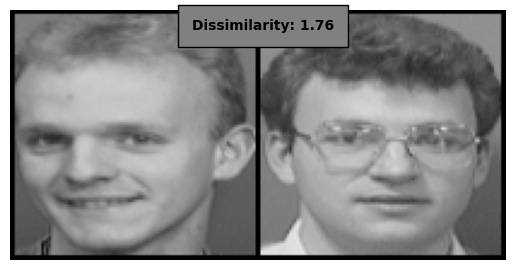

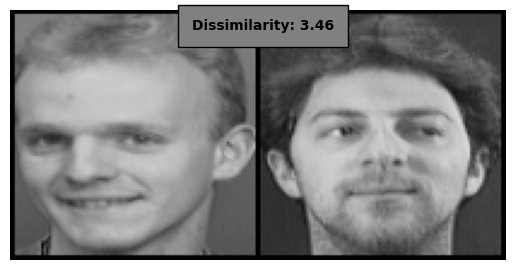

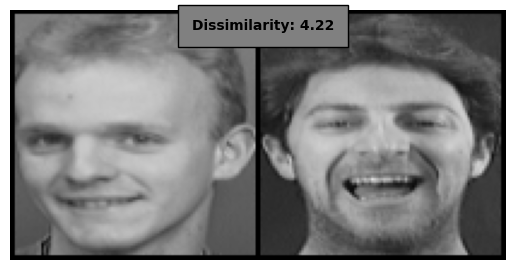

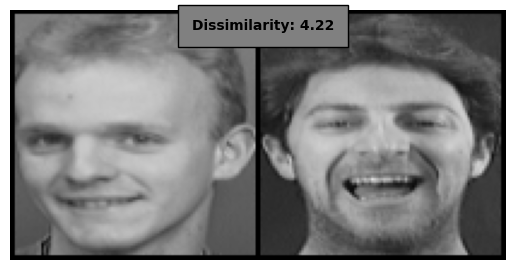

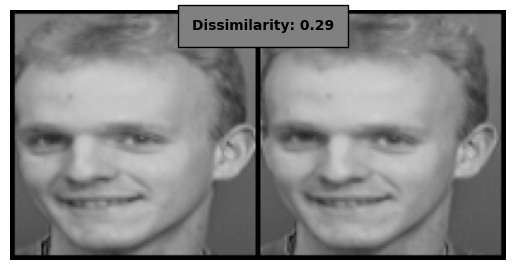

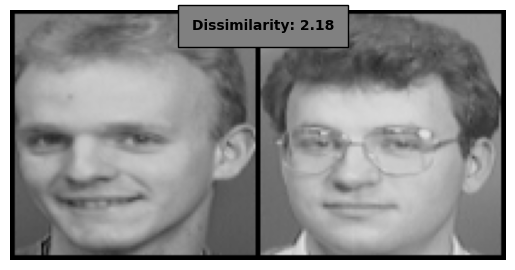

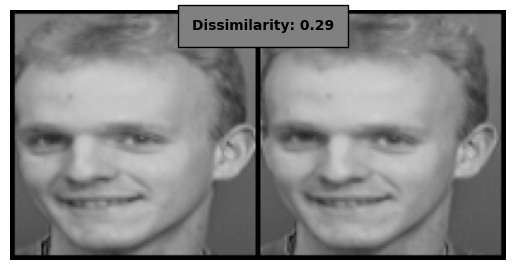

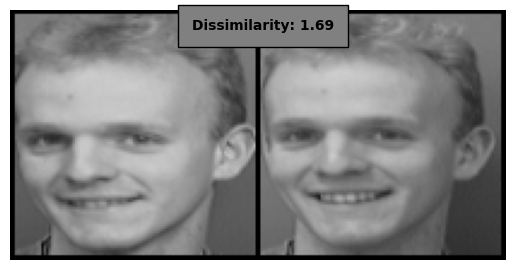

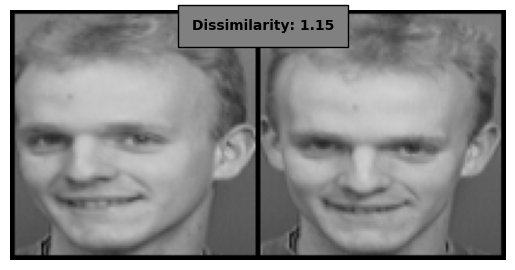

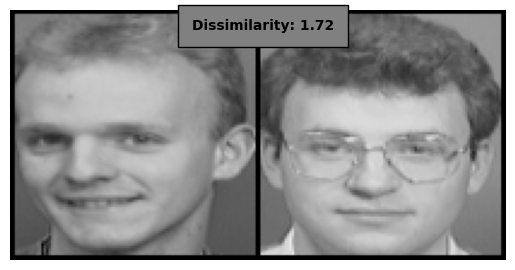

In [29]:
folder_dataset_test = ImageFolder(root="./faces/testing/")

siamese_test_dataset = SiameseNetworkDataset(ImageFolderDataset=folder_dataset_test,
                                        transform=transformation)
test_dataloader = DataLoader(siamese_test_dataset, batch_size=1, shuffle=True)

# Grab one image that we are going to test
dataiter = iter(test_dataloader)

_, x0, label1 = next(dataiter)

for i in range(10):
    _, x1, label2 = next(dataiter)
    concatenated = torch.cat((x0, x1), 0)
    
    output1, output2 = model(x0.cuda(), x1.cuda())
    euclidean_distance = F.pairwise_distance(output1, output2)
    show_img(torchvision.utils.make_grid(concatenated), f'Dissimilarity: {euclidean_distance.item():.2f}')
